# Dual Weighted Reisdual Estimate

In this problem we revisit the Re-entrant Corner Problem but instead of
a classical residual estimator we use a dual weighted residual estimator.
The aim will be to refine the grid to reduce the error at a given point.

Here we will consider the classic _re-entrant corner_ problem,
\begin{align*}
-\Delta u &= f, && \text{in } \Omega, \\
u &= g, && \text{on } \partial\Omega,
\end{align*}
where the domain is given using polar coordinates,
\begin{gather*}
\Omega = \{ (r,\varphi)\colon r\in(0,1), \varphi\in(0,\Phi) \}~.
\end{gather*}
For the boundary condition $g$, we set it to the trace of the function $u$, given by
\begin{gather*}
u(r,\varphi) = r^{\frac{\pi}{\Phi}} \sin\big(\frac{\pi}{\Phi} \varphi \big)
\end{gather*}

In [1]:
import matplotlib
matplotlib.rc( 'image', cmap='jet' )
import math
import numpy
import matplotlib.pyplot as pyplot
from dune.fem.plotting import plotPointData as plot
import dune.grid as grid
import dune.fem as fem
import dune.common as common
import dune.generator.algorithm as algorithm
from dune.fem.view import adaptiveLeafGridView as adaptiveGridView
from dune.fem.space import lagrange as solutionSpace
from dune.alugrid import aluConformGrid as leafGridView
from ufl import *
from dune.ufl import DirichletBC, expression2GF


# set the angle for the corner (0<angle<=360)
cornerAngle = 320.

# use a second order space
order = 2

We first define the domain and set up the grid and space.
We need this twice - once for a computation on a globally refined grid
and once for an adaptive one so we put the setup into a function:

We first define the grid for this domain (vertices are the origin and 4
equally spaced points on the unit sphere starting with (1,0) and
ending at (cos(cornerAngle), sin(cornerAngle))

Next we define the model together with the exact solution.

In [2]:
def setup():
    vertices = numpy.zeros((8, 2))
    vertices[0] = [0, 0]
    for i in range(0, 7):
        vertices[i+1] = [math.cos(cornerAngle/6*math.pi/180*i),
                         math.sin(cornerAngle/6*math.pi/180*i)]
    triangles = numpy.array([[2,1,0], [0,3,2], [4,3,0],
                             [0,5,4], [6,5,0], [0,7,6]])
    domain = {"vertices": vertices, "simplices": triangles}
    gridView = adaptiveGridView( leafGridView(domain) )
    gridView.hierarchicalGrid.globalRefine(2)
    space = solutionSpace(gridView, order=order)

    from dune.fem.scheme import galerkin as solutionScheme
    u = TrialFunction(space)
    v = TestFunction(space)
    x = SpatialCoordinate(space.cell())

    # exact solution for this angle
    Phi = cornerAngle / 180 * pi
    phi = atan_2(x[1], x[0]) + conditional(x[1] < 0, 2*pi, 0)
    exact = dot(x, x)**(pi/2/Phi) * sin(pi/Phi * phi)
    a = dot(grad(u), grad(v)) * dx

    # set up the scheme
    laplace = solutionScheme([a==0, DirichletBC(space, exact, 1)], solver="cg",
            parameters={"newton.linear.preconditioning.method":"jacobi"})
    uh = space.interpolate(0, name="solution")
    return uh, exact, laplace

uh, exact, laplace = setup()

Now we can setup the functional which will be $J(v)=v(P)$ where
$P=(0.4,0.4)$ is some point in the computational domain at which we want
to minimize the error. To compute the dwr estimator we need the solution
to the dual problem with right hand side $J(\varphi_i)$ for all basis
functions $\varphi_i$. This is not directly expressible in UFL and we
therefore implement this using a small C++ function which we then export
to Python:

.. literalinclude:: laplace-dwr.hh

In [3]:
from dune.fem.scheme import galerkin as solutionScheme
spaceZ = solutionSpace(uh.space.grid, order=order+1)
u = TrialFunction(spaceZ)
v = TestFunction(spaceZ)
x = SpatialCoordinate(spaceZ)
a = dot(grad(u), grad(v)) * dx
dual = solutionScheme([a==0,DirichletBC(spaceZ,0)], solver="cg")
z = spaceZ.interpolate(0, name="dual")
zh = uh.copy(name="dual_h")
point = common.FieldVector([0.4,0.4])
pointFunctional = z.copy("dual_rhs")
eh = expression2GF( uh.space.grid, abs(exact-uh), order=order+1 )
computeFunctional = algorithm.load("pointFunctional", "laplace-dwr.hh",
            point, pointFunctional, eh)

In [4]:
from dune.fem.space import finiteVolume as estimatorSpace
from dune.fem.operator import galerkin as estimatorOp

fvspace = estimatorSpace(uh.space.grid)
estimate = fvspace.interpolate([0], name="estimate")

u = TrialFunction(uh.space.as_ufl())
v = TestFunction(fvspace)
n = FacetNormal(fvspace.cell())
estimator_ufl = abs(div(grad(u)))*abs(z-zh) * v * dx +\
                abs(inner(jump(grad(u)), n('+')))*abs(avg(z-zh)) * avg(v) * dS
estimator = estimatorOp(estimator_ufl)
tolerance = 1e-6

Let us solve over a loop (solve,estimate,mark) and plot the solutions side by side.

2 : size= 49 estimate= 0.002773695614243907 error= 0.0011091132557272804
5 : size= 119 estimate= 0.0005955196981941461 error= 0.00041193297812404264


8 : size= 229 estimate= 0.00019266436957539914 error= 0.00013897852476409003


11 : size= 434 estimate= 6.033700030154327e-05 error= 4.200781903458564e-05


14 : size= 781 estimate= 1.9769223179420948e-05 error= 1.3764017987928842e-05


17 : size= 1373 estimate= 6.318305098703605e-06 error= 4.355596056617092e-06


20 : size= 2395 estimate= 2.1307065742291077e-06 error= 1.4447009936817993e-06


23 : size= 4228 estimate= 6.72294777027486e-07 error= 4.423665718305294e-07


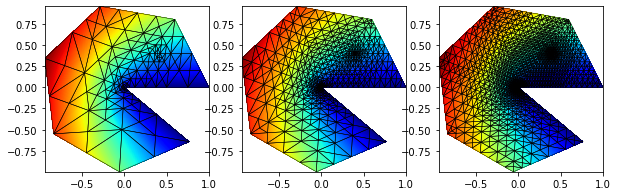

In [5]:
h1error = dot(grad(uh - exact), grad(uh - exact))
fig = pyplot.figure(figsize=(10,10))
count = 0
errorVector    = []
estimateVector = []
dofs           = []
while True:
    laplace.solve(target=uh)
    if count%9 == 8:
        plot(uh, figure=(fig, 131+count//9), colorbar=False)
    pointFunctional.clear()
    error = computeFunctional(point, pointFunctional,eh)
    dual.solve(target=z, rhs=pointFunctional)
    zh.interpolate(z)
    estimator(uh, estimate)
    eta = sum(estimate.dofVector)
    dofs           += [uh.space.size]
    errorVector    += [error]
    estimateVector += [eta]
    if count%3 == 2:
        print(count, ": size=", uh.space.grid.size(0), "estimate=", eta, "error=", error)
    if eta < tolerance:
        break
    marked = fem.mark(estimate,eta/uh.space.grid.size(0))
    fem.adapt(uh) # can also be a list or tuple of function to prolong/restrict
    fem.loadBalance(uh)
    count += 1
plot(uh, figure=(fig, 131+2), colorbar=False)
pyplot.show()
pyplot.close('all')

Let's take a close up look of the refined region around the point of
interest and the origin:

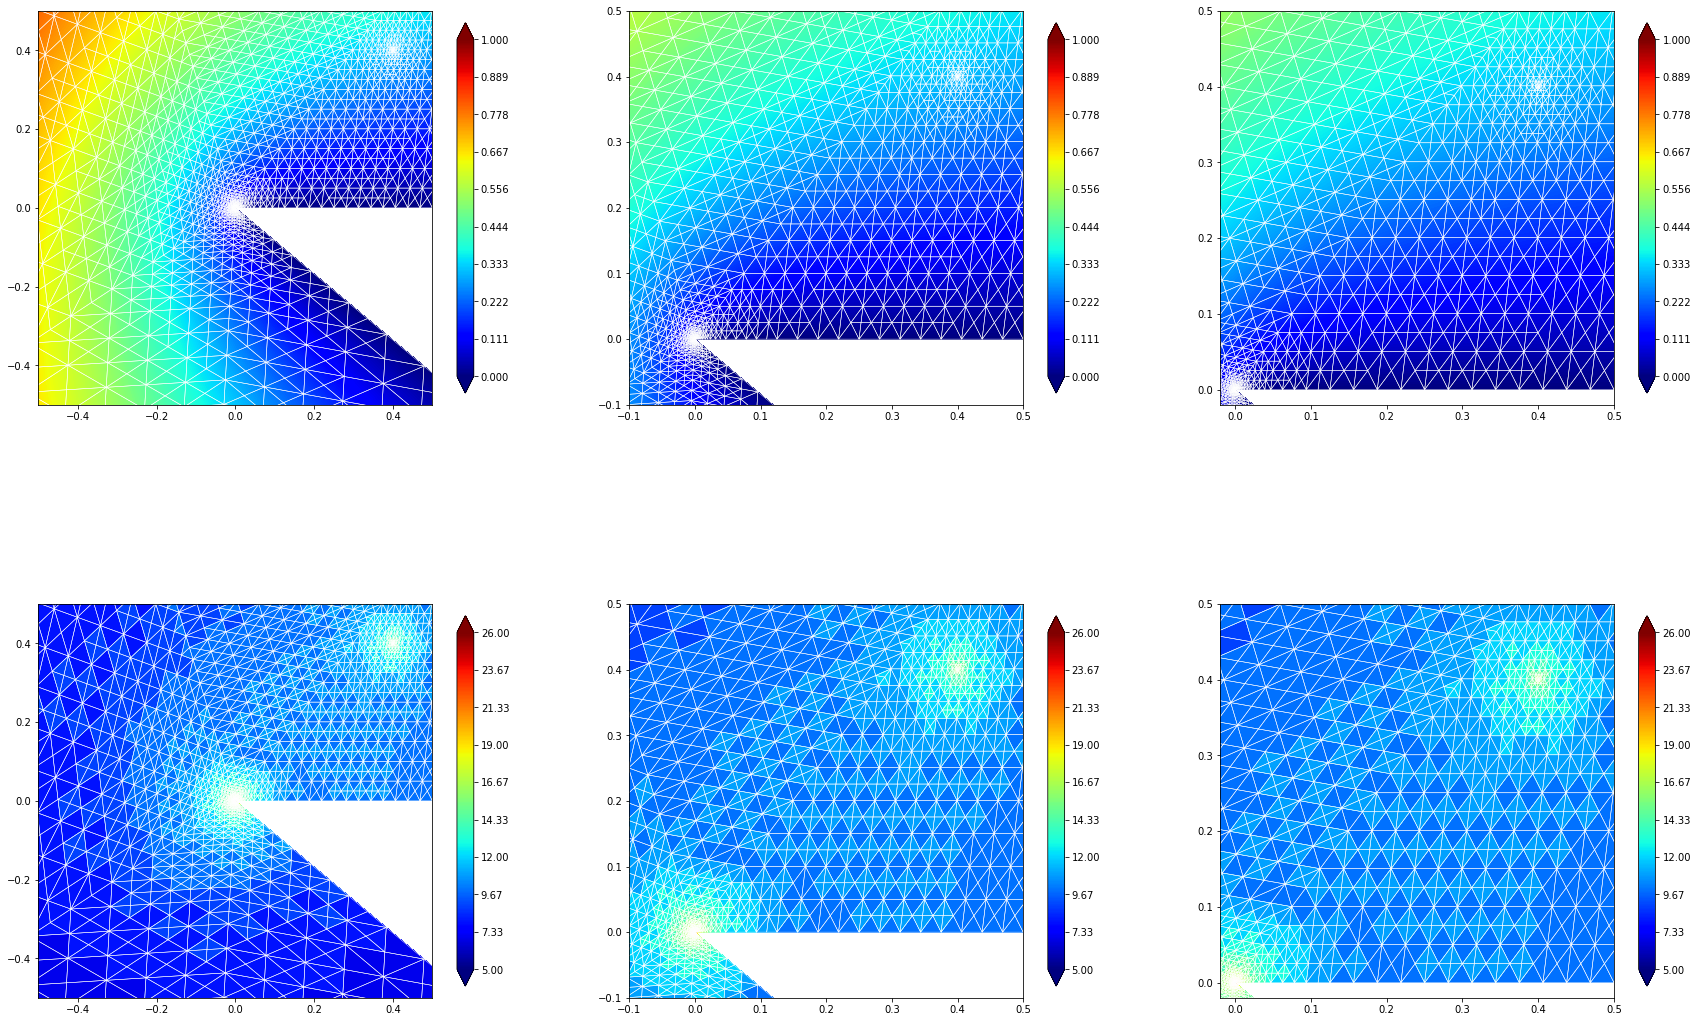

In [6]:
fig = pyplot.figure(figsize=(30,20))
plot(uh, figure=(fig, 231), xlim=(-0.5, 0.5), ylim=(-0.5, 0.5),
        gridLines="white", colorbar={"shrink": 0.75})
plot(uh, figure=(fig, 232), xlim=(-0.1, 0.5), ylim=(-0.1, 0.5),
        gridLines="white", colorbar={"shrink": 0.75})
plot(uh, figure=(fig, 233), xlim=(-0.02, 0.5), ylim=(-0.02, 0.5),
        gridLines="white", colorbar={"shrink": 0.75})

from dune.fem.function import levelFunction
levels = levelFunction(uh.space.grid)
plot(levels, figure=(fig, 234), xlim=(-0.5, 0.5), ylim=(-0.5, 0.5),
        gridLines="white", colorbar={"shrink": 0.75})
plot(levels, figure=(fig, 235), xlim=(-0.1, 0.5), ylim=(-0.1, 0.5),
        gridLines="white", colorbar={"shrink": 0.75})
plot(levels, figure=(fig, 236), xlim=(-0.02, 0.5), ylim=(-0.02, 0.5),
        gridLines="white", colorbar={"shrink": 0.75})
pyplot.show()
pyplot.close('all')